# Aqua Circuit Interoperability Update

_Donny Greenberg, Julien Gacon, Ali Javadi, Steve Wood, 24-Mar-19_

## Basic Vision & End Goal

* Make Aqua use circuits as a first-class currency, and feel more like an algorithms library _next to_ Terra, as users expect, rather than an independent library on top of it
    * No more `construct_circuit()` wrappers in Aqua
* Promote Aqua’s best circuity features into Terra to be broadly useful

## Proposal - Three steps

1. Circuit as a First-class Citizen in Aqua
    1. Aqua algorithms accept circuits directly, no more circuit wrappers
1. Circuit Library with Enhanced QuantumCircuit Families and Convenient Prebuilts
    1. Destination for most of Aqua's enhanced circuit wrappers
    1. Critically, allows for lazily constructed circuit placeholders.
1. Usability Improvements to Promote up to QuantumCircuit
    1. Make circuit construction in Terra more powerful with features in Aqua users like

## 1. Circuit as a First-class Citizen in Aqua

* Anywhere previously calling `construct_circuit` now accepts circuits as-is, no questions asked
* Typehints ask for a circuit, and are indifferent whether a circuit is from the circuit library (below)
* Fully backwards compatible with Aqua's `construct_circuit`-based objects as long as we like
* Maybe warnings where behavior is strange, e.g. no parameters in VQE ansatz

### Demo - VQC with newly built circuits

Below, we demonstrate the execution of the Variational Quantum Classifier using no special circuit construction objects.

In [3]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.aqua.algorithms import VQC
from qiskit.aqua.components.optimizers import SLSQP

import numpy as np
import itertools

In [4]:
# Learning the one-hot encoding
train_feats = np.eye(3).tolist()
train_labels = [1,2,3]
train = dict(zip(train_labels, train_feats))
print(train)

{1: [1.0, 0.0, 0.0], 2: [0.0, 1.0, 0.0], 3: [0.0, 0.0, 1.0]}


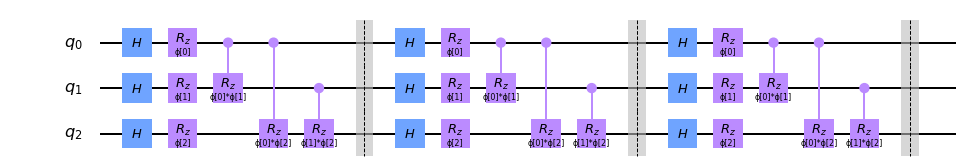

In [5]:
feat_params = ParameterVector('ɸ', length=len(train_feats[0]))
feat_map = QuantumCircuit(3)
depth = 3
for _ in range(depth):
    feat_map.h(qubit=range(3))
    [feat_map.rz(phi=p, qubit=i) for i, p in enumerate(feat_params)]
    [feat_map.crz(theta=p1*p2, control_qubit=q1, target_qubit=q2) 
         for ((q1, p1), (q2,p2)) in itertools.combinations(enumerate(feat_params), 2)]
    feat_map.barrier()
feat_map.draw(output='mpl')

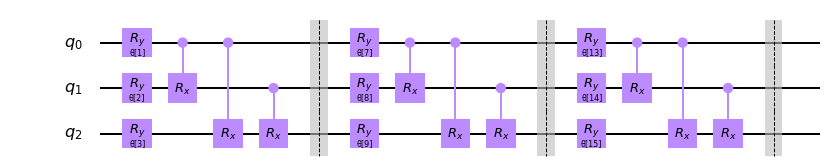

In [6]:
# Note: I need to calculate this number
classifier_params = ParameterVector('θ', length=19)
classifier = QuantumCircuit(3)
depth = 3
cp_iter = iter(classifier_params)
next(cp_iter)
for _ in range(depth):
    [classifier.ry(theta=next(cp_iter), qubit=j) for j in classifier.qubits]
    [classifier.crx(theta=next(cp_iter), control_qubit=q1, target_qubit=q2) 
         for (q1, q2) in itertools.combinations(classifier.qubits, 2)]
    classifier.barrier()
classifier.draw(output='mpl')

In [ ]:
vqc = VQC(optimizer=SLSQP(), 
          data_circuit=feat_map, 
          classifier_circuit=classifier, 
          training_dataset=train, 
          test_dataset=train)
vqc.run()

## 2. Circuit Library with Enhanced Flexibility Circuits and Convenient Prebuilts

_Proposal: Move Aqua's circuit-constructor objects - e.g. Ansatze, QFTs, Arithmetic - into a broadly useful circuit-library as flexible QuantumCircuit objects with enhanced features._

#### New Concepts in the Circuit Library
* Circuit Blueprints: Enhanced QuantumCircuit objects which are lazily populated and constructed, but print and interact as bona-fide circuits.
    * Not a new class, simply subclasses of QuantumCircuit which match the QuantumCircuit interface
    * Users generally shouldn't notice the difference, unless digging into circuit guts in debugging
    * Properties such as `.data`, `.parameters`, etc. which require real circuits, trigger construction and caching of constructed circuit
    * Meta-parameters, such as ansatz depth or connectivity, are mutable and edited lightly due to lazy construction. Setters trigger cached circuit wipe
* Circuit Families
    * Collections of circuit blueprints or prebuilt circuits with extensions or use-case specific features - e.g. `PermutationCircuit`s can include properties which `ArithmeticCircuit`s do not.
    * Allow for more aggressive convenience functionality for specific use cases e.g. Ansatz automatically allocating parameters during construction.

#### Options for Circuit Library Placement
1.   Inside Terra, with integration tests
    1. Pros - Consistent with user expectations that Terra contains circuit building blocks
    1. Cons - Unlike other areas, Terra has many directories in the base qiskit level, include `qiskit/circuit/`. The library could not clearly be a `circuits` directory alongside Terra, but would likely be hidden inside `qiskit/circuit/library/`. May complicate Aqua development, requiring frequent multi-repo PRs and exactly synced releases.
1.   Inside Aqua, with Qiskit-wide utility, no Aqua concepts
    1. Pros - Can be placed in a `qiskit/circuit_library` directory alongside `qiskit/aqua`, giving clear delineation as an important library of circuits. 
    1. Cons - Users may not expect to find this in Aqua, and distinction between "complicated Terra gate" (e.g. MCT) and "simple library circuit" would make keeping these so far apart strange.
1.   In its own repo
    1. Pros - Clear importance and delineation.
    1. Cons - Another repo.

#### Options for Circuit Family Organization
The circuit library is still a work in progress. In each of the below options, we can make all of the circuits importable from the base init, allowing us to iterate on the directory organization without breaking changes to circuit usage. This way, we can ensure that the circuits are in the correct location in Qiskit for Aqua to begin using them, rather than wait for the library to be complete, and then execute a breaking change to merge in Aqua's circuits. 

1. **Organize By Circuit Purposes**
    1. Data Preparation Circuits
        1. Data Feature Maps
        1. Probability Distributions
    1. NLocal Circuits (name pending - needs to reflect purpose and availability of Optimization-specific features and properties, such as optimization_bounds and auto-parameterization).
        1. TwoLocalCircuit
        1. NLocalCircuit
        1. Ry, RyRz, SwapRz
    1. Arithmetic Circuits
        1. Adders
        1. Reciprocals
        1. MCTs
        1. Hamming weight
    1. Basis Change Circuits
        1. QFTs
            1. QFT Placeholder/Base
            1. QFT circuits
        1. QWT Circuits
        1. DCT Circuits
        1. Pauli Basis Change
    1. Oracle Circuits
        1. Truth table
        1. Logical expression
        1. Phase oracle
        1. Permutation oracle
    1. Function Testing Circuits
        1. Fourier Checking
        1. Hidden shift with Bent Boolean functions
        1. Ideal Hidden Linear Function circuits
    1. Benchmarking
        1. Near-Clifford / graph states
        1. Random uniform
        1. Quantum Volume
        1. CNOT Dihedral (from Ignis)

1. **Organize By Circuit Form Factors** - Organization followed by internal quantum-circuits repo. Methodology is organization by the subcircuits and organization of the circuits themselves.
    1. Random uniform
    1. NLocal Circuits
        1. NLocal, TwoLocal, Ry, RyRz, SwapRz
        1. Linear rotation
    1. Near-Clifford / graph states
        1. Pauli Basis Change
    1. Quantum volume
    1. Quantum Fourier transform
    1. Ideal HLF circuits
    1. Hamming weight
    1. Hidden shift with bent Boolean functions
    1. Multiply-controlled NOT gate
    1. IQP circuits
    1. Fourier checking
    1. Unresolved - It's unclear into which families the following circuits fall in the above grouping:
        1. Artimetic
            1. QFT vs. CNOT based adders
            1. Cutoff vs. long-division based reciprocals
        1. Oracle circuits
        1. Data Feature Maps
            1. Broader than forrelation by accepting different paulis to evolve, rather than just Z^n, but also each only half of a forrelation circuit
            1. Can be other classes of hard circuits, not only forrelation-based

1.   **Some Purpose, Some Complexity Families** - Allow both circuit purpose families and circuit form-factor families, allowing for custom enhancements or functionality in either family type. Circuits can act as placeholders (e.g. permutation) to be filled in by a choice of several synthesis implementations later. Circuits can also import circuits from other families so both practical and theoretical expectations are met without code duplication.
    1. Data Preparation Circuits
        1. Data Feature Maps
        1. Probability Distributions
    1. Arithmetic Circuits
    1. Basis Change Circuits
        1. Quantum Fourier Transform Circuits
    1. Oracle Circuits
    1. N Local Circuits
        1. NLocal, TwoLocal, Ry, RyRz, SwapRz
    1. Near-Clifford / Graph State Circuits
    1. Quantum Volume Circuits
    1. Ideal Hidden Linear Function Circuits
    1. Hamming Weight Circuits
    1. Hidden Shift with Bent Boolean Function Circuits
    1. Multiply-controlled NOT Gate Circuits
    1. IQP Circuits
    1. Fourier Checking Circuits
  
1. **Two Subdirectories** - One corresponding to circuit purpose families, one corresponding to circuit complexity families. All circuits can be imported from `qiskit.circuit.library` so organization is aesthetic.
    1. Circuit Purpose Families
        1. Data Preparation Circuits
            1. Data feature maps
            1. probability_distributions
        1. NLocal Circuits
            1. TwoLocalCircuit, NLocalCircuit, Ry, RyRz, SwapRz
        1. Arithmetic Circuits
        1. Basis Change Circuits
            1. QFT, QWT, DCT
            1. Pauli Basis Change
        1. Oracle Circuits - Truth table, Logical expression, Phase oracle, Permutation oracle
    1. Circuit Complexity Families
        1. Random uniform
        1. Hardware efficient
        1. Near-Clifford / graph states
        1. Quantum volume
        1. Quantum Fourier transform
        1. Ideal HLF circuits
        1. Hamming weight
        1. Hidden shift with bent Boolean functions
        1. Multiply-controlled NOT gate
        1. IQP circuits
        1. Fourier checking
    
_Additional Proposal: HardwareEfficient base class - abstract `target_backend` setter (QFTs, adders, NLocal, etc. can choose how to interpret what to do with backend information and provide specially tailored circuits for hardware which are not available by transpilation alone.)_

##### Organization Recommendation
Begin with Option 1 _quietly_ to be able to migrate the circuits out of Aqua, and reorganize within the library as it is formally built out and new circuit families are added. This is functionally identical to Option 3, as the form-factor circuit families are not yet ready to be pushed to the library, and will need to be merged as a separate step. This will also allow for more time and deliberation about this complex organization question. Allowing all circuits to be imported from the base circuit library directory prevents the impending reorganizations from introducing breaking changes.

### Demo 2 - Powerful New QuantumCircuit Objects

In [8]:
from chemistry.code.molecule import Molecule
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.aqua.algorithms import VQE
# from qiskit.circuit_.library import RyRz

from qiskit import BasicAer
qasm = BasicAer.get_backend('qasm_simulator')

In [ ]:
hh = Molecule(geometry=[['H', [0., 0., 1.]],
                       ['H', [0., 0.45, 1.]],
                       ])
hamiltonian = hh.get_qubitop_hamiltonian()
molecular_wf = HartreeFock(hh) + RyRz(depth=3, entanglement='linear')
gse = VQE(wf_ansatz=molecular_wf, optimizer=SLSQP, backend=qasm).compute_minimum_eigenvalue(hamiltonian)
print(gse)

In [ ]:
molecular_qf.target_backend = IBMQ.get_backend('ibmq_valencia')

## 3. QuantumCircuit Usability Improvements

Aqua's circuit_constructors have accumulated many powerful features not present in QuantumCircuit. No changes are strictly needed to QuantumCircuit to support the above proposals, but we can promote some of these improvements up to QuantumCircuit base to make these features broadly available.

*   Suggested for immediate promotion:
    *   Mutable qubit number (delete qubits, or extend circuit) for anonymous register circuits
    *   `.parameters` returns a list instead of a set, as parameter randomization is inconvenient
*   Further opportunities for radical circuit control
    *   Lazy parameterization - When no parameter is specified in a parameterized standard gate, create a new one for the user. We can do this lazily, and only create the full list when `.parameters` is called, in which case the list is "locked in."
    *   Lazy broadcasting - Similar to the NLocal Circuits. Allow the user to specify groups of qubits to which to apply a gate in circuit construction, but only construct these duplicates when the circuit data is actually needed. Allow users to manipulate these gate applications.
    *   What we’d need to do to implement these two

Demo 4 - Interface demo of further opportunities

In [ ]:
# Working notes - Captures new features but doesn't highlight them exactly
my_c = QuantumCircuit(4)
my_c.h(qubits='all')
my_c.cu3(qubits='full', theta=.5) # other two parameters are set to be parameterized under the hood
my_c.h(qubits='all')
my_c.rz(qubits='all', phi=Parameter('theta')) # Sets the same parameter for all of them